In [495]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import thinkstats2
import thinkplot
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, confusion_matrix, log_loss, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import binarize
from sklearn.pipeline import make_pipeline
import statsmodels.formula.api as sm


# Assignment 4 - Classification

For this assignment, you'll need to perform a classification on a dataset, as well as do some prep work on the data. 

The exact steps of what you need to do are flexible and up to you to some degree, however you should consider some of the important things we've mentioned recently, such as:
<ul>
<li> Is the target balanced?
<li> Are there missing or erroneous values?
<li> Are there categorical or numerical features?
<li> Is there colinearity?
<li> Are there outliers?
<li> Should we normalize? 
<li> Do the distributions of the features give any indication that some may need work? 
</ul>

Basically, the data is in the original, potentially dirty, format, and you need to find what should be cleaned, and do the cleaning. There is not one "right" answer to what has to be done, and you'll probably need to do it with at least something of an iterative process - find an issue, correct it, check the data, repeat.

<b>The target that we are predicting is the loan_status. </b>

## Grading

The grades will be broken down as follows:
<ul>
<li> <b>30%</b> - a working predictive model with a reasonable level of accuracy. 
    <ul>
    <li> For the accuracy part, it will not be explicitly graded, but compared to all the others. If you're in the same general range, that's good - if yours is drastically less accurate (or, I guess more accurate), then I'll adjust. There won't be a comparison of "this person is 72.3% and this person is only 71.8% accurate, they fail."
    <li> This data is larger than most of the small sample sets, so random variations due to train-test splits shouldn't be too bad. (If you're a keener you could loop)
    <li> I will use the F1 score as the accuracy metric. 
    </ul>
<li> <b>40%</b> - a clear and readable description of what steps you took to prepare the data, and a brief not on the rationale behind it. Did you do a log transformation to a skewed feature, did you remove outliers, did you remove a feature that has a lot of missing values? Please put this somewhere obvious and readable, consider the goal of the assignment to explain your process to me. 
    <ul>
    <li> E.g. "The target data was imbalanced, so I tried several resampling methods and chose the one with the highest accuracy of the resulting model", "the feature X had the same value for 95% of records, so I dropped it". 
    <li> In this, please also state if you see a group that appears to be a good credit risk, and a group that is a bad credit risk, and indicate the evidence showing that. Please do this other than the most simplistic way - more money = better credit. If there are no such groups, state why you think this. This will likely be about 3 - 5 statements or points, you should provide evidence from the data, but it does not need to be an essay. (You may want to consider this question after you're pretty much done with the data prep and modelling.)
    </ul>
<li> <b>30%</b> - allowing your model to be "deployed". At the bottom of this file there is a small block of code to load in some test data (that I have), and calculate your accuracy. Your contribution to this part is to have a model that is ready to make predictions. Some specifics to consider:
    <ul>
    <li> The test data will be in exactly the same format as the dataset you're given. So any steps that you took to prepare your data for modelling will need to be mirroed here, so the new  data can be predicted. The easiest way to do this is to use a pipeline, but it is up to you. Remember the model only accepts data that is in a certain format - the one that you had the data in when it was trained, so when making predictions you need to make sure that is true. 
    <li> Since I'm providing test data, and your task is to just create a model, think about how that might impact your train-test splitting, both as you're developing and for the final product. 
    <li> Once the model is trained it should predict any data that is in the right format, so I should be able to provide any proper dataset, click run on that testing cell, and get predictions. I will not be doing anything that will purposefully make this harder or trickier, like including data that has errors or is in the wrong format, I just split the entire set of data, reserved part of it to test accuracy, and gave the rest to you. Things that you've changed (e.g. dropping a column, one-hot encoding) do need to be replicated at some point before the model can accept the new data to predict. In general we <b>do</b> want to check in our processing that our input is valid, this is kind of a junior introduction to that. 
    </ul>
</ul

## Load Credit Data

In [496]:
df = pd.read_csv("train.csv")
df.head(10)

,Unnamed: 0,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,26967,27,120000,MORTGAGE,3.0,PERSONAL,B,14000,11.99,0,0.12,N,10
1,8449,24,58000,MORTGAGE,8.0,DEBTCONSOLIDATION,A,15700,7.90,0,0.27,N,3
2,20983,30,45000,RENT,11.0,MEDICAL,C,5000,12.73,1,0.11,Y,8
3,19612,35,35000,MORTGAGE,5.0,EDUCATION,B,5600,11.49,0,0.16,N,6
4,30371,38,55000,RENT,0.0,EDUCATION,C,6500,11.03,0,0.12,Y,12
5,30932,39,60000,RENT,4.0,DEBTCONSOLIDATION,A,4300,7.49,0,0.07,N,17
6,886,21,12000,RENT,1.0,EDUCATION,C,1000,13.98,0,0.08,N,2
7,10225,26,55000,RENT,4.0,VENTURE,A,9600,7.66,0,0.17,N,2
8,190,26,66996,RENT,10.0,PERSONAL,D,25000,15.21,1,0.37,Y,2
9,8324,25,57000,OWN,5.0,PERSONAL,C,12000,13.23,0,0.21,N,3


In [497]:
def convert_prob_to_label(prob, cutoff = 0.5):
    label = []
    for i in range(len(prob)):
        if prob[i] > cutoff:
            label.append(1)
        else:
            label.append(0)
    return label

In [498]:

df.describe()

,Unnamed: 0,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,26064.000000,26064.000000,2.606400e+04,25350.000000,26064.000000,23575.000000,26064.000000,26064.000000,26064.000000
mean,16307.473258,27.738375,6.602795e+04,4.791440,9595.886088,11.006839,0.216812,0.170264,5.805210
std,9396.129345,6.381305,6.265098e+04,4.100277,6321.894580,3.245217,0.412082,0.106673,4.055158
min,0.000000,20.000000,4.080000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,8202.250000,23.000000,3.879375e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,16324.500000,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,24458.250000,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,32580.000000,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [499]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26064 entries, 0 to 26063
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  26064 non-null  int64  
 1   person_age                  26064 non-null  int64  
 2   person_income               26064 non-null  int64  
 3   person_home_ownership       26064 non-null  object 
 4   person_emp_length           25350 non-null  float64
 5   loan_intent                 26064 non-null  object 
 6   loan_grade                  26064 non-null  object 
 7   loan_amnt                   26064 non-null  int64  
 8   loan_int_rate               23575 non-null  float64
 9   loan_status                 26064 non-null  int64  
 10  loan_percent_income         26064 non-null  float64
 11  cb_person_default_on_file   26064 non-null  object 
 12  cb_person_cred_hist_length  26064 non-null  int64  
dtypes: float64(3), int64(6), object

In [500]:
df.isna().sum()

Unnamed: 0                       0
person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              714
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 2489
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [501]:
df = df.dropna()
df.isna().sum()

Unnamed: 0                    0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

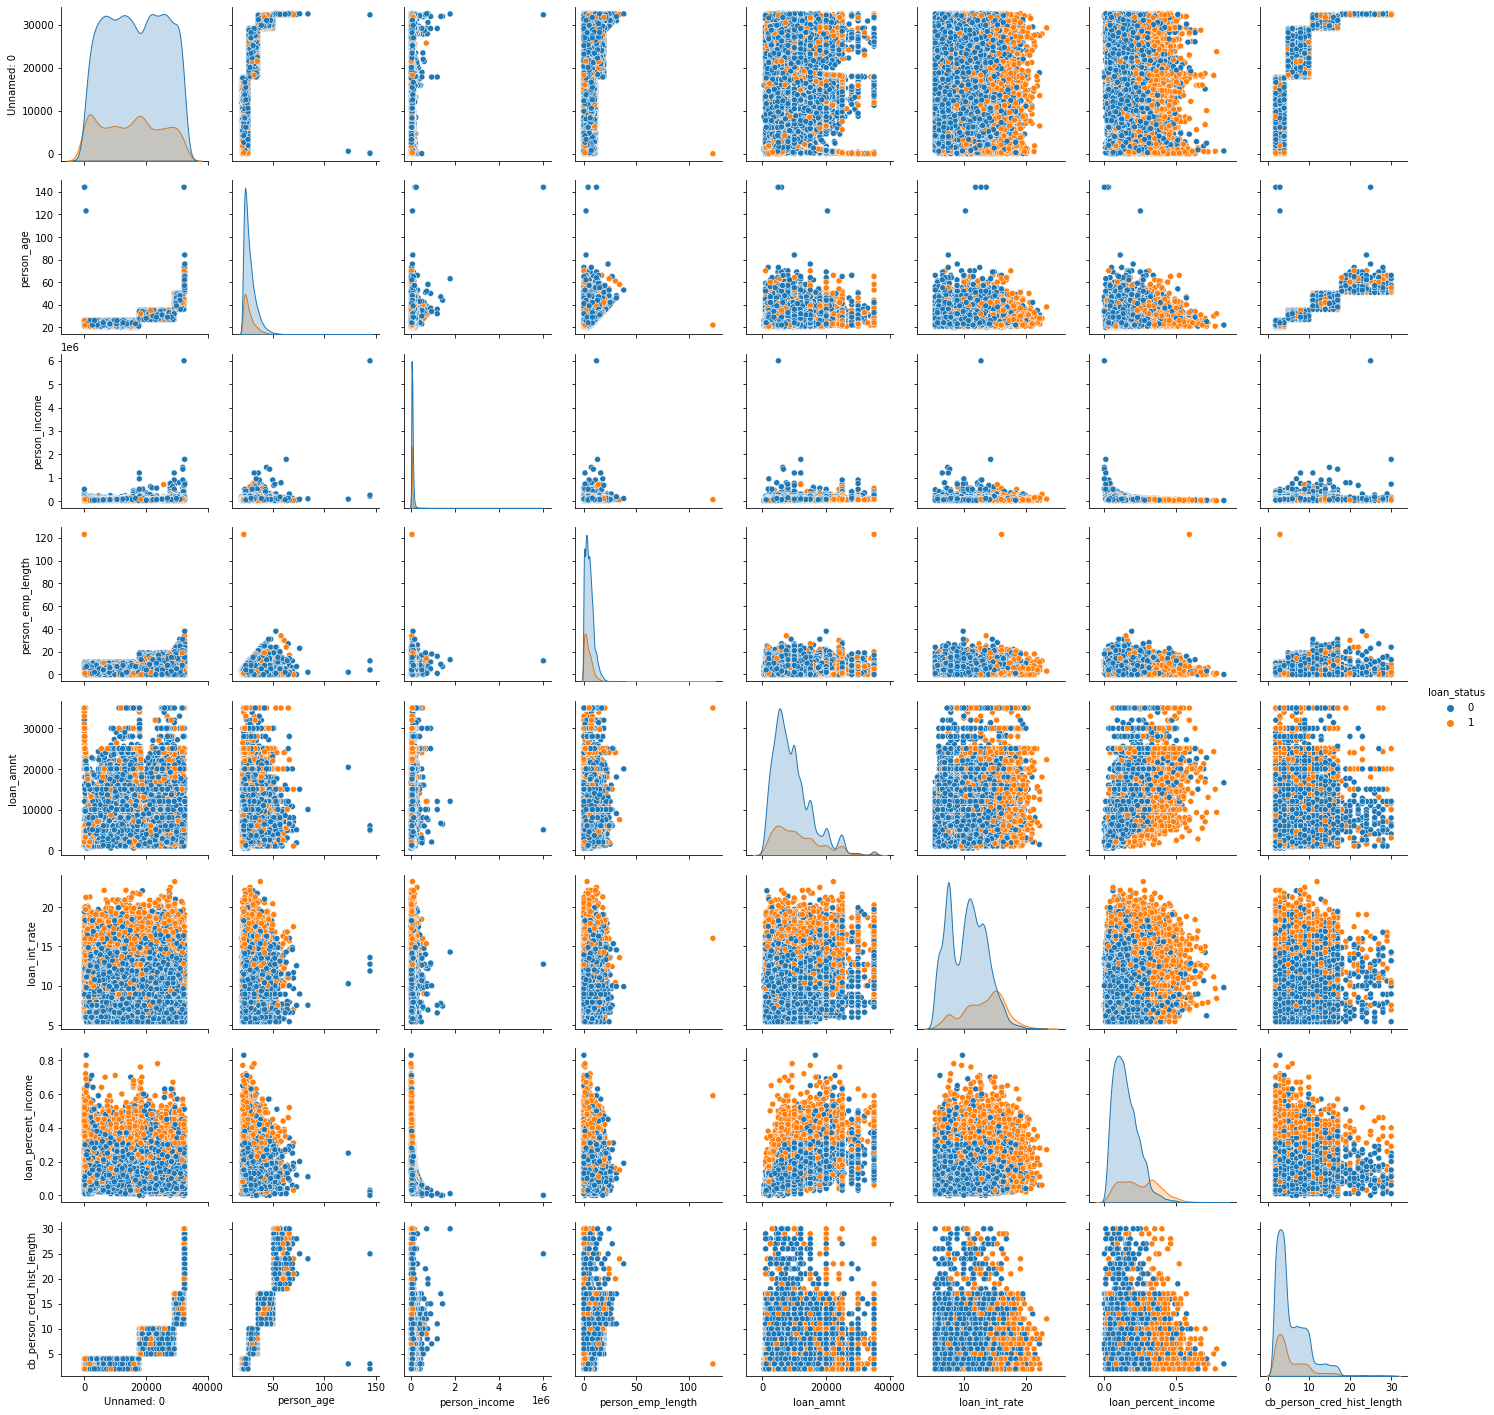

In [502]:
sns.pairplot(df, hue="loan_status")

In [503]:

df2 = df[df['person_income'] < 1000000]
df2 = df2[df["person_age"] < 100]
df2 = df2[df["person_emp_length"] < 60] 

C:\Users\Luke\AppData\Local\Temp\ipykernel_15660\393214768.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df2[df["person_age"] < 100]
C:\Users\Luke\AppData\Local\Temp\ipykernel_15660\393214768.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df2[df["person_emp_length"] < 60]


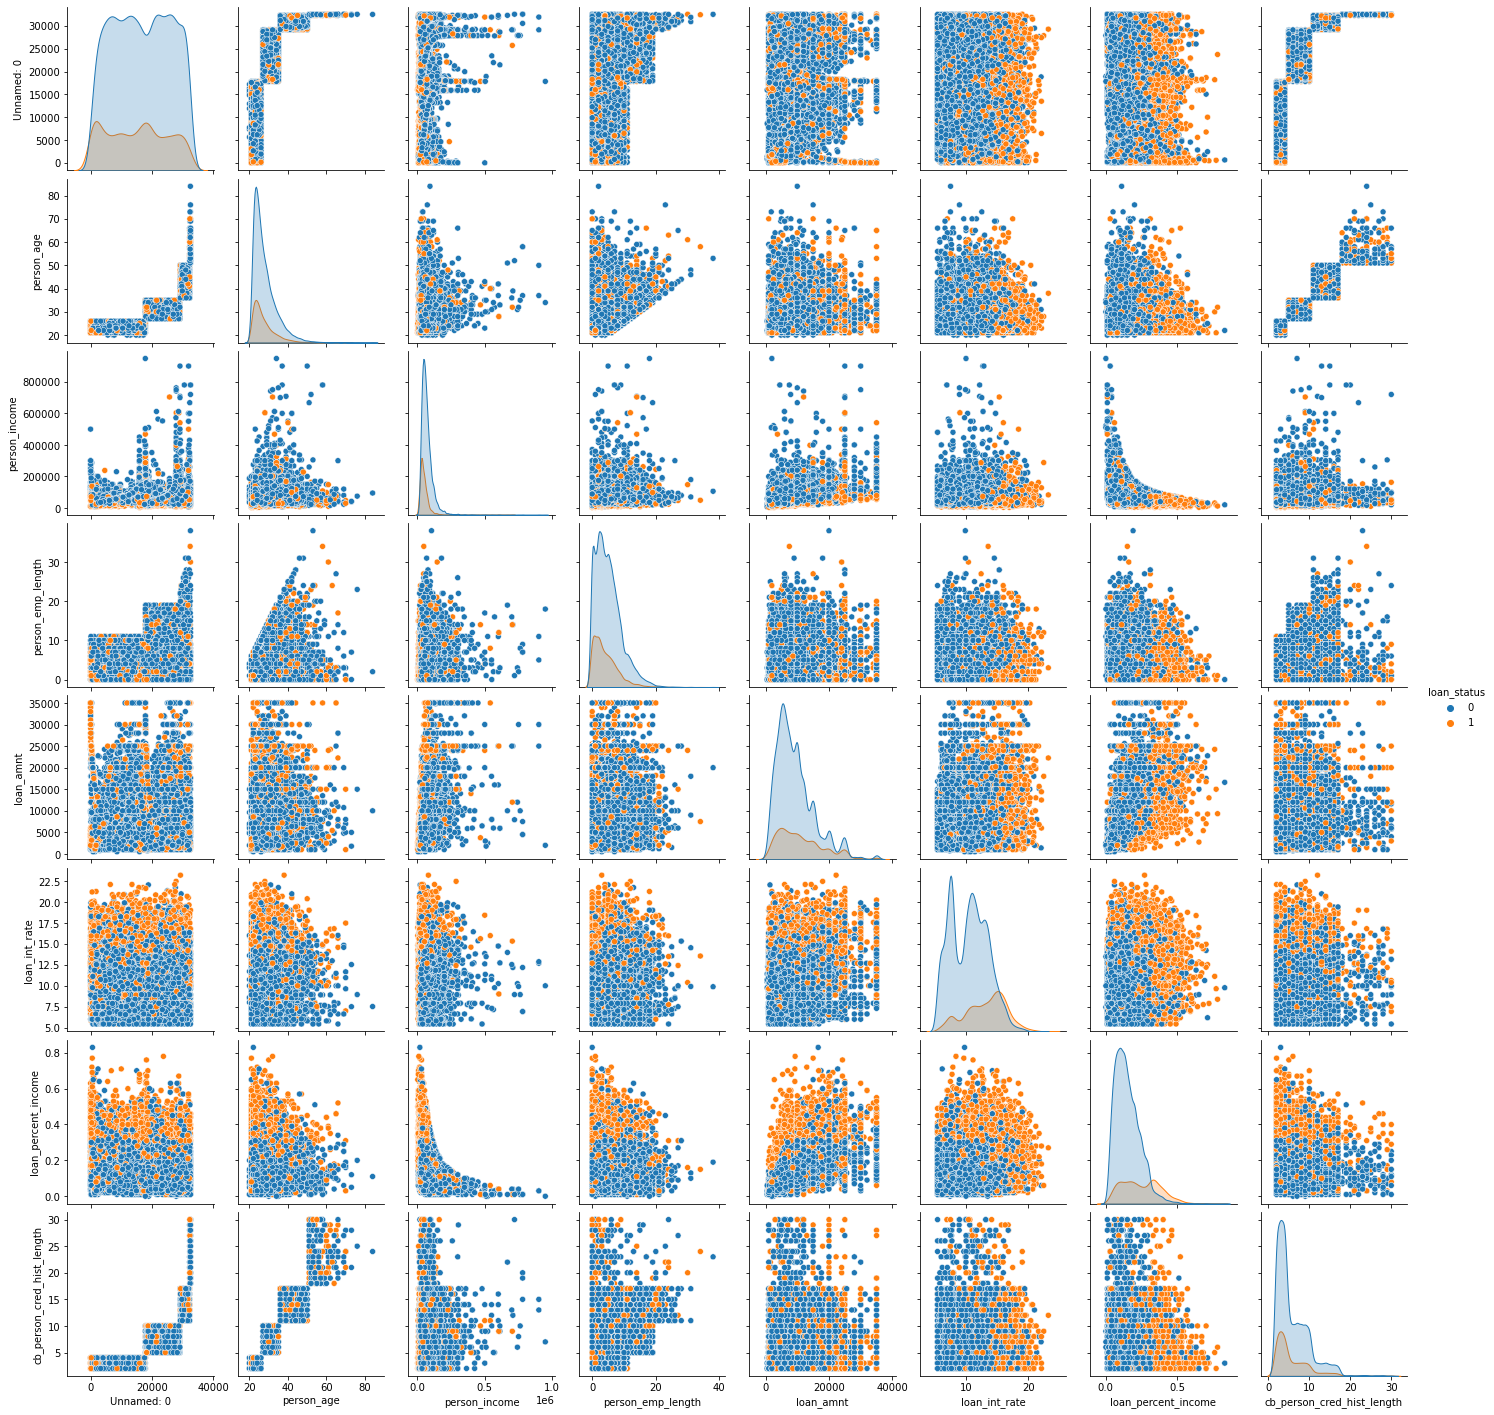

In [504]:
sns.pairplot(df2, hue="loan_status")

In [505]:
df2_ = pd.get_dummies(df2, drop_first=True)
df2_.head()

,Unnamed: 0,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
0,26967,27,120000,3.0,14000,11.99,0,0.12,10,0,...,0,1,0,1,0,0,0,0,0,0
1,8449,24,58000,8.0,15700,7.90,0,0.27,3,0,...,0,0,0,0,0,0,0,0,0,0
2,20983,30,45000,11.0,5000,12.73,1,0.11,8,0,...,1,0,0,0,1,0,0,0,0,1
3,19612,35,35000,5.0,5600,11.49,0,0.16,6,0,...,0,0,0,1,0,0,0,0,0,0
4,30371,38,55000,0.0,6500,11.03,0,0.12,12,0,...,0,0,0,0,1,0,0,0,0,1


In [506]:
dfYP = df2_["loan_status"]
dfXP = df2_.drop(columns={"loan_status"}) #There isn't generally a need to standardize the Y values

xP = np.array(dfXP)
yP = np.array(dfYP).reshape(-1,1)
xP.shape, yP.shape

((22909, 23), (22909, 1))

In [507]:
X_trainP, X_testP, y_trainP, y_testP = train_test_split(xP, yP, test_size=0.33)

F1: 0.6496952312656867
Acc: 0.8707671957671957
LogLoss: 4.46356894693063


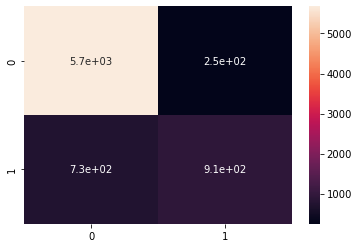

In [508]:
m2 = make_pipeline( StandardScaler(),
                    LogisticRegression()
                    )

# Use pipeline like it is a model. 
m2.fit(X_trainP, y_trainP.ravel())
m2_pred = m2.predict(X_testP)

labelsP = convert_prob_to_label(np.array(m2_pred))
conf_matrixP= confusion_matrix(y_testP,labelsP)
sns.heatmap(conf_matrixP, annot=True)

print("F1:",f1_score(y_testP, labelsP))
print("Acc:",accuracy_score(y_testP, labelsP))
print("LogLoss:", log_loss(y_testP, labelsP))

In [509]:
1 - df["loan_status"].mean()

0.7841965181726951

In [510]:

from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

Resampled dataset shape Counter({0: 11992, 1: 11633})
F1: 0.8129445234708392
Acc: 0.9304232804232804
Recall: 0.7197732997481109
Precision: 0.9338235294117647


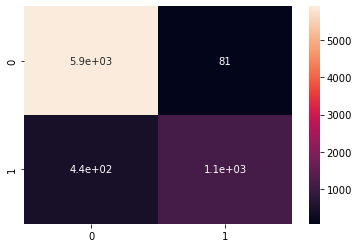

In [511]:
sampler = ADASYN(n_jobs=-1)
#Split Data x/y
y1 = np.array(df2_["loan_status"]).reshape(-1,1)
x1 = np.array(df2_.drop(columns={"loan_status"}))

Xtrain, xtest, ytrain, ytest = train_test_split(x1, y1, test_size=0.33)

#Look at relative imbalance after split
X_train5Samp, y_train5Samp = sampler.fit_resample(Xtrain, ytrain)
print('Resampled dataset shape %s' % Counter(y_train5Samp))

#Normalize data
#scaler = MinMaxScaler()
scaler = MinMaxScaler()
X_train5_norm = scaler.fit_transform(X_train5Samp)
X_test5_norm = scaler.transform(xtest)

#Train model
model = RandomForestClassifier(n_jobs=-1).fit(X_train5_norm,y_train5Samp.ravel())
#Make predictions
preds = model.predict(X_test5_norm)

#Generate 1/0 results and show results
prediction_labels = binarize(np.array(preds).reshape(-1,1), threshold=.5)
conf_matrix5 = confusion_matrix(ytest,prediction_labels)
sns.heatmap(conf_matrix5, annot=True)

print("F1:",f1_score(ytest, prediction_labels))
print("Acc:",accuracy_score(ytest, prediction_labels))
print("Recall:",recall_score(ytest, prediction_labels))
print("Precision:",precision_score(ytest, prediction_labels))

### Accuracy Test

Replace the green part with whatever you need to transform the fresh data into the format needed for your model to predict. 

<b>Note:</b> you could test and make sure that things are working OK here by taking part of your dataset, saving it in a separate CSV, and running it through here as a piece of test data. The accuracy results would be useless, but you'd confirm that the model works properly. 

F1: 0.3926419283222328


<AxesSubplot:>

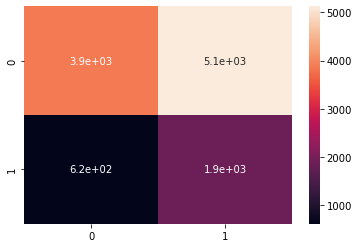

In [512]:
d_test = pd.read_csv("Test1.csv")


df_test1 = d_test[d_test['person_income'] < 1.0e+06]
df_test1 = df_test1[df_test1["person_age"] < 100]
df_test1 = df_test1[df_test1["person_emp_length"] < 60] 



df_test1[['person_home_ownership','loan_intent', 'loan_grade', 'cb_person_default_on_file'  ]] = df_test1[['person_home_ownership','loan_intent', 'loan_grade', 'cb_person_default_on_file']].astype('category')
df_test1 = pd.get_dummies(df_test1, drop_first=True) 

df_test1 = df_test1.dropna()


ytest = np.array(df_test1["loan_status"]).reshape(-1,1)
xtest = np.array(df_test1.drop(columns={"loan_status"})) 


prediction = model.predict(xtest)


prediction_labels = binarize(np.array(prediction).reshape(-1,1), threshold=.5)
######################
# Insert whatever you need to do to prep the data here. 
# It might be nothing if you have a big pipeline. 
# Ensure that at the end your data is in two arrays - xtest and ytest
# Ensure the name of your final model is "model"
# Each should contain the ENTIRE x or y dataset in the test data. 
#
# This part should be reusable - any dataset in this format should just run
# and generate predictions and accuracy stats. 
# Please DO NOT do any train-test splitting here. 
#######################

# This should work once you're done, as is. 
# uncomment the stuff below when ready to run.
print("F1:",f1_score(ytest, prediction_labels))
conf_matrix= confusion_matrix(ytest, prediction_labels)
sns.heatmap(conf_matrix, annot=True)

### Description of Work

##### The first notable thing I did when addressing this was described the data just to get a good look at some basic statistics. 

##### Got a look at the data info just to make sure our data types were in the right order.

##### Then I moved on to check if there was nulls in the data to which i discovered there were and removed them so our data will model nicely. 

##### Made a pairplot dividing loan status, this allowed me to see if there was any big outliers effecting the data 

##### I decided on filtering personal income less than 1 million as there seemed to be some people way above that up to 6 milliion. I think for this case I think it is better to focus on average persons income as thats where most of our data is sitting. I also filtered age less than 100 as there were apparently 140 year olds in the data? Unless its vampires of course. I also had 1 of those vampires working for about 120 years so i filtered him out so we could just focus on our average 40 year work cycle. 

##### Then I started the prep work to create a logistic regression model. I started by using get dummies to change all of our categorical data to something usable for our model. I also did the reshape and printed the result just to make sure the data was split properly. 

##### I then did the train, test and split

##### Then i moved on to making a pipeline where i was easily able to put in my arguments for scaling and logistic regression. I decided to try using both minmax and standard scaler but ultimately decided standard was better as it provided a slightly more accurate model.

##### I then created my logistic regression model and ran it with the results of around 0.65 F1 and accuracy of about 0.87 and thought it was alright but i thought maybe there was a better way to predict the data due to the type of data we have. I also looked at our baseline accuracy just to compare how the model was doing. 

##### This is where i decided to use a random forest as i looked into and researched a bit more as to how they worked. Ultimately though, i decided on using this one because everywhere i looked said that the random forest was better when there is a lot of categorical data present and also if our data is very lage and hard to interperet. Which i think in this scenario all applies. 

##### I ended up using min max scaler for the random forest as it gave me more accuracy, I also had to do some importing but in the end it was worth it! I got results that were pretty much bang on as compared to my logistic regression model 

##### Then lastly I had to convert everything i did so my model could be used for some test data. I took a subset of the data from excel just so i could see if i could run my model against it. I had to still do the get dummies and drop nans stuff but the most notable issue i had with it was getting the same data types to match up for my test data. For some reason it was not reading it as 'Category', so i changed that and everything ran smoothly. My F1 for the test is not all that accurate but the point was to see if i could get my model running for some other data.

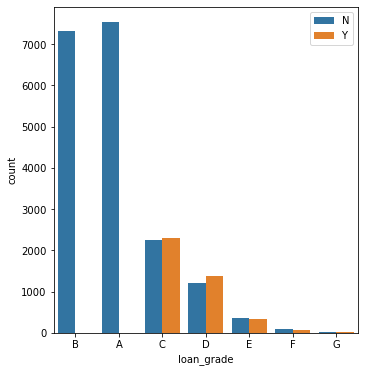

In [513]:
thinkplot.PrePlot(2,1,2)
sns.countplot(data=df2, x="loan_grade", hue="cb_person_default_on_file")
thinkplot.Config()

#### By looking at this histogram we can also see that people with a better loan grade (A,B) are way less likely to default on their loans, in fact according to this they dont at all! This can indicate that if you have a higher loan grade then you probably have a better credit rating. Also You can see that people who have defaulted have a grade of C,D,E,F or G. This says that if you have defaulted you probably have a worse loan grade and also probably have a worse credit rating.